In [ ]:
#| default_exp timeseries_plots

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from typing import Callable, Iterable, Optional, Union, Tuple
import warnings

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from pheno_utils.config import DEFAULT_PALETTE, TIME_FORMAT, LEGEND_SHIFT

In [ ]:
#| export
class TimeSeriesFigure:
    def __init__(self, figsize: tuple = (10, 6), padding: float = 0.05):
        """
        Initialize a TimeSeriesFigure instance. This class is used to create and manage
        a figure with multiple axes for time series data.
        
        Args:

            figsize (tuple): Size of the figure (width, height) in inches.
            padding (float): The amount of padding to add between axes as a fraction of the figure height.
        """
        self.fig = plt.figure(figsize=figsize)
        self.axes: Iterable[tuple] = []
        self.axis_names: dict = {}
        self.padding = padding
        self.custom_paddings = {}  # To store custom padding for specific axes
        self.shared_x_groups = []  # To keep track of shared x-axis groups

    def plot(
        self, 
        plot_function: Callable, 
        *args, 
        n_axes: int = 1, 
        height: float = 1, 
        sharex: Union[str, int, plt.Axes] = None, 
        second_y: bool = False,
        name: str = None, 
        ax: Union[str, int, plt.Axes] = None, 
        adjust_time: Optional[str] = 'union',
        adjust_by_axis: Union[str, int, plt.Axes, Iterable[Union[str, int, plt.Axes]]] = None,
        **kwargs
    ) -> Union[plt.Axes, Iterable[plt.Axes]]:
        """
        Plot using a dataset-specific function, creating a new axis if needed.
        The plot function should accept the axis object as the argument `ax`, or
        a list of axes if multiple axes are used.
        
        Args:

            plot_function (Callable): The dataset-specific function to plot the data.
            *args: Arguments to pass to the plot function.
            n_axes (int): The number of axes required. Default is 1.
            height (float): The proportional height of the axes relative to a single unit axis.
            sharex (str, int, or plt.Axes): Index or name of the axis to share the x-axis with. If None, the x-axis is independent.
            second_y (bool): If True, plot will be done on a secondary y-axis in the plot. Default is False.s
            name (str): Name or ID to assign to the axis.
            ax (plt.Axes, str, int): Pre-existing axis (object, name, or index) or list of axes to plot on.
            adjust_time (str, None): Method to adjust the time limits of all axes to match the data.
            adjust_by_axis (str, int, plt.Axes): Axes (single or multiple) to use as a reference for adjusting the time limits.
            **kwargs: Keyword arguments to pass to the plot function.
        
        Returns:

            Union[plt.Axes, Iterable[plt.Axes]]: A single axis object or a list of axis objects if multiple axes are used.
        """
        if ax is None:
            ax = self.add_axes(height=height, n_axes=n_axes, sharex=sharex, name=name)
        else:
            ax = self.get_axes(ax, squeeze=True)

        if second_y:
            ax.yaxis.grid(False)
            ax = ax.twinx()

        plot_function(*args, ax=ax, **kwargs)
        if adjust_time:
            self.set_time_limits(None, None, method=adjust_time, reference_axis=adjust_by_axis)
        if second_y:
            ax.yaxis.grid(False)
            ax.yaxis.label.set_rotation(90)
            ax.yaxis.label.set_ha('center')

        return ax

    def add_axes(
        self, 
        height: float = 1, 
        n_axes: int = 1, 
        sharex: Optional[Union[str, int, plt.Axes]] = None, 
        name: Optional[str] = None,
    ) -> Union[plt.Axes, Iterable[plt.Axes]]:
        """
        Add one or more axes with a specific proportional height to the figure.
        
        Args:

            height (float): The proportional height of each new axis relative to a single unit axis.
            n_axes (int): The number of axes to create.
            sharex (str, int, or plt.Axes): Index or name of the axis to share the x-axis with. If None, the x-axis is independent.
            name (Optional[str]): Name or ID to assign to the axis (only valid if num_axes=1).
        
        Returns:

            Union[plt.Axes, Iterable[plt.Axes]]: A single axis object or a list of axis objects if multiple axes are created.
        """
        new_axes = []
        shared_group = []
        
        if sharex is not None:
            sharex = self.get_axes(sharex)[0]
            shared_group.append(sharex)

        for _ in range(n_axes):
            ax = self.fig.add_subplot(len(self.axes) + 1, 1, len(self.axes) + 1, sharex=sharex)
            new_axes.append(ax)
            self.axes.append((ax, height))
            shared_group.append(ax)
            # When creating mulitple axes, always share their x-axis with the first one
            if sharex is None:
                sharex = ax
        
        if shared_group:
            self.shared_x_groups.append(shared_group)

        if name is not None:
            self.axis_names[name] = new_axes
        
        self._adjust_axes()

        return new_axes if n_axes > 1 else new_axes[0]

    def _adjust_axes(self) -> None:
        """
        Adjust the positions and sizes of all axes based on their proportional height and apply padding.
        """
        total_height = sum(height for _, height in self.axes)
        total_padding = self.padding * (len(self.axes) - 1)
        bottom = 1 - total_padding  # Start from the top of the figure

        for i, (ax, height) in enumerate(self.axes):
            ax_height = height / total_height * (1 - total_padding)
            # Adjust for any custom padding before this axis
            custom_pad = self.custom_paddings.get(i, 0)
            ax.set_position([0.1, bottom - ax_height, 0.8, ax_height])
            bottom -= ax_height + self.padding + custom_pad  # Move down, considering padding

    def _get_axis_by_name(self, name: str) -> Optional[plt.Axes]:
        """
        Retrieve an axis by its name or ID.
        
        Args:

            name (str): The name or ID of the axis to retrieve.
        
        Returns:

            Optional[plt.Axes]: The corresponding axis object if found, otherwise None.
        """
        return self.axis_names.get(name, [])

    def get_axes(self, ax: Union[str, int, plt.Axes, Iterable[Union[str, int, plt.Axes]]]=None, squeeze=False) -> Iterable[plt.Axes]:
        """
        Retrieve the axis object(s) based on the input type.

        Args:

            ax: The axis object, index, name, or list of those to retrieve.
            squeeze (bool): Whether to return a single axis object if only one is found.
        
        Returns:

            Iterable[plt.Axes]: A list of axis objects.
        """
        if ax is None:
            return [a for a, _ in self.axes]
        elif not isinstance(ax, list):
            ax = [ax]
        
        ax_list = []
        for a in ax:
            if isinstance(a, str):
                by_name = self._get_axis_by_name(a)
                if len(by_name) == 0:
                    warnings.warn(f"No axis found with name '{a}'")
                ax_list.extend(by_name)
            elif isinstance(a, int):
                ax_list.append(self.axes[a][0])

        if squeeze and len(ax_list) == 1:
            return ax_list[0]
        else:
            return ax_list

    def print_shared_axes(self):
        """
        Print which axes in the figure share their x-axis.
        """
        shared_groups = {}
        for i, (ax, _) in enumerate(self.axes):
            for j, (other_ax, _) in enumerate(self.axes):
                if i != j and ax.get_shared_x_axes().joined(ax, other_ax):
                    if i not in shared_groups:
                        shared_groups[i] = []
                    shared_groups[i].append(j)

        for ax_idx, shared_with in shared_groups.items():
            print(f"Axis {ax_idx} shares its x-axis with: {shared_with}")

    def get_axis_properties(self, ax: Union[str, int, plt.Axes, Iterable[Union[str, int, plt.Axes]]]=None) -> dict:
        """
        Get the properties of a specific axis or axes.
        
        Args:

            ax (str, int, plt.Axes, or a list of those): The axis or axes to get the properties for.
        
        Returns:

            dict: A dictionary of properties for the axis or axes.
        """
        ax_list = self.get_axes(ax)
        properties = {}
        for a in ax_list:
            properties = {key: properties.get(key, []) + [value] for key, value in a.properties().items()}

        for k, v in properties.items():
            if len(v) == 1:
                properties[k] = v[0]

        return properties

    def set_axis_properties(self, ax: Union[str, int, plt.Axes, Iterable[Union[str, int, plt.Axes]]]=None, **kwargs) -> None:
        """
        Set properties for a specific axis or axes.
        
        Args:

            ax (str, int, plt.Axes, or a list of those): The axis or axes to set the properties for.
            **kwargs: Additional keyword arguments to pass to the axis object.
        """
        ax_list = self.get_axes(ax)
        for a in ax_list:
            a.set(**kwargs)

    def set_axis_padding(self, padding: float, ax: Union[str, int, plt.Axes, Iterable[Union[str, int, plt.Axes]]]=None, above: bool = True) -> None:
        """
        Set custom padding for a specific axis.
        
        Args:

            padding (float): The amount of padding to add as a fraction of the figure height.
            ax (str, int, plt.Axes, or a list of those): The axis or axes to set the padding for.
            above (bool): Whether to add padding above the axis (default) or below.
        """
        ax_list = self.get_axes(ax)
        all_axes = [a for a, _ in self.axes]

        for ax in ax_list:
            axis_index = all_axes.index(ax)
            if axis_index < 0:
                warnings.warn("Axis not found in the figure.")
                continue
            if above:
                self.custom_paddings[axis_index] = padding
            elif axis_index == len(self.axes) - 1:
                continue
            else:
                self.custom_paddings[axis_index + 1] = padding
            self._adjust_axes()

    def set_time_limits(
            self, start_time: Union[float, str, pd.Timestamp, None],
            end_time: Union[float, str, pd.Timestamp, None],
            method: str='union',
            reference_axis: Union[str, int, plt.Axes, Iterable[Union[str, int, plt.Axes]]] = None
    ) -> None:
        """
        Set the time limits for all axes in the figure. Calling with None will adjust the limits to the data.

        Args:

            start_time (Union[float, str, pd.Timestamp, None]): The start time for the x-axis.
            end_time (Union[float, str, pd.Timestamp, None]): The end time for the x-axis.
            method (str): The method to use to adjust the time limits. Can be 'union' or 'intersect'.
            reference_axis (str, int, plt.Axes, or a list of those): The axis or axes to use as a reference for adjusting the time limits.
        """
        # Default values
        xlim = np.array(self.get_axis_properties(reference_axis)['xlim']).reshape((-1, 2))
        if method == 'union':
            xlim = xlim[:, 0].min(), xlim[:, 1].max()
        elif method == 'intersect':
            xlim = xlim[:, 0].max(), xlim[:, 1].min()
        else:
            raise ValueError(f"Invalid method: {method} not in ['union', 'intersect']")

        # Convert string inputs to pandas Timestamp objects
        if start_time is not None:
            start_time = pd.to_datetime(start_time)
        else:
            start_time = xlim[0]
        if end_time is not None:
            end_time = pd.to_datetime(end_time)
        else:
            end_time = xlim[1]

        self.set_axis_properties(xlim=(start_time, end_time))

    def set_periodic_ticks(
        self, 
        interval: Union[str, pd.Timedelta], 
        start_time: str = '2018-01-01 00:00',
        end_time: str = None,
        fmt=TIME_FORMAT,
        ax: Union[str, int, plt.Axes, Iterable[Union[str, int, plt.Axes]]] = None
    ) -> None:
        """
        Set periodic x-ticks at a regular interval throughout the day.

        Args:

            interval (Union[str, pd.Timedelta]): The interval between ticks (e.g., '1H' for hourly ticks, '30T' for 30 minutes).
            start_time (str): The time of day to start the ticks from (default is '00:00').
            end_time (str): The time of day to end the ticks at (default is None).
            fmt (str): The date format string to be used for the tick labels.
            ax (str, int, plt.Axes, or a list of those): The axis (or axes) to apply the ticks to. 
                Can be an axis object, a list of axes, an index, or a name. If None, applies to all axes.
        """
        # Convert interval to pandas Timedelta if it's a string
        if isinstance(interval, str):
            interval = pd.to_timedelta(interval)

        # Convert start_time to a datetime object with today's date
        if start_time is not None:
            start_time = pd.to_datetime(start_time).tz_localize(None)
        if end_time is not None:
            end_time = pd.to_datetime(end_time).tz_localize(None)

        # Determine which axes to apply this to
        axes = self.get_axes(ax)

        for a in axes:
            if a is not None:
                # Get the x-axis limits
                min_x, max_x = a.get_xlim()

                # Convert limits to datetime if they are in float format
                if isinstance(min_x, (float, int)):
                    min_x = mdates.num2date(min_x).replace(tzinfo=None)
                if isinstance(max_x, (float, int)):
                    max_x = mdates.num2date(max_x).replace(tzinfo=None)

                # Set the ticks to align with the start_datetime
                ticks = pd.date_range(start=start_time if start_time else min_x,
                                      end=end_time if end_time else max_x,
                                      freq=interval)

                # Make sure ticks are within the limits
                ticks = [tick for tick in ticks if min_x <= tick and tick <= max_x]

                # Set the locator and formatter
                format_xticks(a, ticks, fmt)

                plt.setp(a.get_xticklabels(), rotation=0, ha='center')

    def add_legend(self, ax: Union[str, int, plt.Axes, Iterable[Union[str, int, plt.Axes]]], **kwargs) -> None:
        """
        Add a legend to a specific axis.
        
        Args:

            axis (str, int, plt.Axes, or a list of those): The axis to add the legend to.
            **kwargs: Additional keyword arguments passed to the legend object.
        """
        ax_list = self.get_axes(ax)
        for a in ax_list:
            a.legend(**kwargs)

    def set_legend(self, ax: Union[str, int, plt.Axes, Iterable[Union[str, int, plt.Axes]]]=None, bbox_to_anchor: tuple=None, **kwargs):
        """
        Update the legend properties for all axes in the figure, or a subset of them, if the legend exists.

        Args:

            axis (str, int, plt.Axes, or a list of those): The name or list of names of axes to update the legend for.
            bbox_to_anchor (tuple, optional): The bounding box coordinates for the legend.
            **kwargs: Additional keyword arguments passed to the legend object.
        """
        ax_list = self.get_axes(ax)

        for a in ax_list:
            legend = a.get_legend()
            if legend is None:
                continue
            if bbox_to_anchor is not None:
                legend.set_bbox_to_anchor(bbox_to_anchor)
            legend.set(**kwargs)

    def show(self) -> None:
        """
        Display the figure.
        """
        plt.show()


def format_xticks(ax: plt.Axes, xticks: Iterable=None, format: str=TIME_FORMAT, **kwargs):
    """ format datestrings on x axis """
    if xticks is None:
        xticks = ax.get_xticks()
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks, **kwargs)
    xfmt = mdates.DateFormatter(format)
    ax.xaxis.set_major_formatter(xfmt)


def format_timeseries(
    df: pd.DataFrame,
    participant_id: int=None,
    array_index: int=None,
    time_range: Tuple[str, str]=None,
    x_start: str='collection_timestamp',
    x_end: str='collection_timestamp',
    unique: bool=False,
) -> pd.DataFrame:
    """
    Reformat and filter a time series DataFrame based on participant ID, array index, and date range.

    Args:

        df (pd.DataFrame): The DataFrame to filter.
        participant_id (int): The participant ID to filter by.
        array_index (int): The array index to filter by.
        time_range: The date range to filter by. Can be a tuple of two dates / times or two strings.
        x_start (str): The name of the column containing the start time.
        x_end (str): The name of the column containing the end time.
        unique (bool): Whether to remove duplicate rows.

    Returns:
        pd.DataFrame: The filtered DataFrame
    """
    if participant_id is not None:
        df = df.query('participant_id == @participant_id')
    if array_index is not None:
        df = df.query('array_index == @array_index')

    # Reset index to avoid issues with slicing and indexing
    x_ind = np.unique([c for c in [x_start, x_end] if c in df.index.names])
    if len(x_ind):
        if np.isin(x_ind, df.index.names).any():
            df = df.reset_index(x_ind)
        df[x_start] = df[x_start].dt.tz_localize(None)
        if x_start != x_end:
            df[x_end] = df[x_end].dt.tz_localize(None)
    if time_range is not None:
        time_range = pd.to_datetime(time_range)
        df = df.loc[(time_range[0] <= df[x_start]) & (df[x_end] <= time_range[1])]
    if unique:
        df = df.drop_duplicates()

    return df.sort_values(x_start)

In [ ]:
#| export
def plot_events_bars(
    events: pd.DataFrame,
    x_start: str = 'collection_timestamp',
    x_end: str = 'event_end',
    y: str = 'event',
    hue: str = 'channel',
    participant_id: Optional[int] = None,
    array_index: Optional[int] = None,
    time_range: Optional[Tuple[str, str]] = None,
    y_include: Optional[Iterable[str]] = None,
    y_exclude: Optional[Iterable[str]] = None,
    legend: bool = True,
    palette: str = DEFAULT_PALETTE,
    alpha: Optional[float] = 0.7,
    ax: Optional[plt.Axes] = None,
    figsize: Tuple[float, float] = (12, 6),
) -> plt.Axes:
    """
    Plot events as bars on a time series plot.

    Args:

        events (pd.DataFrame): The events dataframe.
        x_start (str): The column name for the start time of the event.
        x_end (str): The column name for the end time of the event.
        y (str): The column name for the y-axis values.
        hue (str): The column name for the color of the event.
        participant_id (int): The participant ID to filter events by.
        array_index (int): The array index to filter events by.
        time_range (Tuple[str, str]): The time range to filter events by.
        y_include (Iterable[str]): The list of values to include in the plot.
        y_exclude (Iterable[str]): The list of values to exclude from the plot.
        legend (bool): Whether to show the legend.
        palette (str): The name of the colormap to use for coloring events.
        alpha (float): The transparency of the bars. Default is 0.7.
        ax (plt.Axes): The axis to plot on. If None, a new figure is created.
        figsize (Tuple[float, float]): The size of the figure (width, height) in inches.
    """
    events, color_map = prep_to_plot_timeseries(
        events, x_start, x_end,
        hue, y,
        participant_id, array_index, time_range,
        y_include, y_exclude,
        palette=palette)
    if hue is None:
        hue = 'hue'

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    # Plot events
    events = events.assign(diff=lambda x: x[x_end] - x[x_start]).sort_values([hue, y])
    y_labels = []
    legend_dicts = []
    for i, (y_label, events) in enumerate(events.groupby(y, observed=True, sort=False)):
        if len(y) == 0:
            continue
        y_labels.append(y_label)
        for c, r in events.groupby(hue, observed=True):
            data = r[[x_start, 'diff']]
            if not len(data):
                continue
            h = ax.broken_barh(data.values, (i-0.4,0.8), color=color_map[c], alpha=alpha)
            legend_dicts.append({'label': c, 'handle': h})

    # format plot
    if legend:
        legend_df = pd.DataFrame.from_dict(legend_dicts).drop_duplicates(subset='label')
        ax.legend(
            legend_df['handle'],
            legend_df['label'],
            loc='upper left', 
            bbox_to_anchor=LEGEND_SHIFT)

    ax.set_yticks(np.arange(len(y_labels)), y_labels)
    format_xticks(ax)
    ax.invert_yaxis()  # Invert y-axis to match the order of the legend

    return ax


def plot_events_fill(
    events: pd.DataFrame,
    x_start: str = 'collection_timestamp',
    x_end: str = 'event_end',
    hue: str = 'channel',
    label: str = None,
    participant_id: Optional[int] = None,
    array_index: Optional[int] = None,
    time_range: Optional[Tuple[str, str]] = None,
    y_include: Optional[Iterable[str]] = None,
    y_exclude: Optional[Iterable[str]] = None,
    legend: bool = True,
    palette: str = DEFAULT_PALETTE,
    alpha: Optional[float] = 0.5,
    ax: Optional[plt.Axes] = None,
    figsize: Iterable[float] = [12, 6],
) -> plt.Axes:
    """
    Plot events as filled regions on a time series plot.

    Args:

        events (pd.DataFrame): The events dataframe.
        x_start (str): The column name for the start time of the event.
        x_end (str): The column name for the end time of the event.
        hue (str): The column name for the color of the event.
        label (str): The column name for the label of the event.
        participant_id (int): The participant ID to filter events by.
        array_index (int): The array index to filter events by.
        time_range (Iterable[str]): The time range to filter events by.
        y_include (Iterable[str]): The list of values to include in the plot.
        y_exclude (Iterable[str]): The list of values to exclude from the plot.
        legend (bool): Whether to show the legend.
        palette (str): The name of the palette to use for coloring events.
        alpha (float): The transparency of the filled regions.
        ax (plt.Axes): The axis to plot on. If None, a new figure is created.
        figsize (Tuple[float, float]): The size of the figure (width, height) in inches.
    """
    events, color_map = prep_to_plot_timeseries(
        events, x_start, x_end,
        hue, label,
        participant_id, array_index, time_range,
        y_include, y_exclude,
        palette=palette)
    if hue is None:
        hue = 'hue'

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    if type(ax) is not list:
        ax = [ax]

    for a in ax:
        # Plotting events
        this_color = hue if hue is not None else '#4c72b0'
        for _, row in events.iterrows():
            if color_map is not None:
                this_color = color_map[row[hue]]
            # Plot the event as a filled region, with zorder to ensure it's behind other elements
            a.axvspan(
                row[x_start], row[x_end], 0, 1,
                color=this_color, alpha=alpha, zorder=0,
                transform=a.get_xaxis_transform())

        # Add labels as xticks on the top secondary x-axis
        if label:
            secax = a.secondary_xaxis('top')
            secax.set_xticks(events[x_start])
            secax.set_xticklabels(events[label], rotation=0, ha='center')

        # Add legend
        if legend:
            # Get existing handles from existing legends in the axes
            handles, labels = a.get_legend_handles_labels()
            if color_map is not None:
                handles += [plt.Rectangle((0, 0), 1, 1, color=c, alpha=alpha) for c in color_map]
                labels += color_map.index.tolist()
            else:
                handles += [plt.Rectangle((0, 0), 1, 1, color=this_color, alpha=alpha)]
                labels += ['events']
            a.legend(handles, labels, loc='upper left', bbox_to_anchor=LEGEND_SHIFT)

        format_xticks(a)

    return ax


def prep_to_plot_timeseries(
    data: pd.DataFrame,
    x_start: str,
    x_end: str,
    hue: str,
    label: str,
    participant_id: int,
    array_index: int,
    time_range: Tuple[str, str],
    y_include: Iterable[str],
    y_exclude: Iterable[str],
    add_columns: Iterable[str]=None,
    palette=DEFAULT_PALETTE,
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Prepare timeseries / events data for plotting.

    Args:

        events (pd.DataFrame): The timeseries / events dataframe.
        x_start (str): The column name for the start time of the event.
        x_end (str): The column name for the end time of the event.
        hue (str): The column name for the color of the event.
        label (str): The column name for the label of the event.
        participant_id (int): The participant ID to filter events by.
        array_index (int): The array index to filter events by.
        time_range (Iterable[str]): The time range to filter events by.
        y_include (Iterable[str]): The list of values to include in the plot.
        y_exclude (Iterable[str]): The list of values to exclude from the plot.
        add_columns (Iterable[str]): Additional columns to include in the plot.
        palette (str): The name of the colormap to use for coloring events.

    Returns:

        Tuple[pd.DataFrame, pd.DataFrame]: The filtered events dataframe and the color map.
    """
    if type(add_columns) is str:
        add_columns = [add_columns]

    data = format_timeseries(data, participant_id, array_index, time_range, x_start, x_end)

    # Filter events based on y_include and y_exclude
    data = data.dropna(subset=[x_start, x_end])
    if hue is not None and hue in data.index.names:
        data = data.reset_index(hue)
    if label is not None and label in data.index.names:
        data = data.reset_index(label)
    if y_include is not None:
        ind = pd.Series(False, index=data.index)
        if hue is not None:
            ind |= data[hue].isin(y_include)
        if label is not None:
            ind |= data[label].isin(y_include)
        data = data.loc[ind]
    if y_exclude is not None:
        ind = pd.Series(False, index=data.index)
        if hue is not None:
            ind |= data[hue].isin(y_exclude)
        if label is not None:
            ind |= data[label].isin(y_exclude)
        data = data.loc[~ind]
    if hue is None:
        hue = 'hue'
        data[hue] = 'events'

    col_list = [x_start, x_end, hue, label]
    if add_columns is not None:
        col_list += list(add_columns)
    col_list = pd.Series(col_list).dropna().drop_duplicates()

    # Set colors
    if hue in data.columns:
        colors = get_color_map(data, hue, palette)
    else:
        colors = None

    return data[col_list], colors


def get_events_period(
    events_filtered: pd.DataFrame,
    period_start: str,
    period_end: str,
    period_name: str,
    col: str = 'event',
    first_start: bool = True,
    first_end: bool = True,
    include_start: bool = True,
    include_end: bool = True,
    x_start: str = 'collection_timestamp',
    x_end: str = 'event_end',
) -> pd.DataFrame:
    """
    Get the period of time between the start and end events.

    Args:

        events_filtered (pd.DataFrame): The events DataFrame.
        period_start (str): The label of the start event.
        period_end (str): The label of the end event.
        period_name (str): The label to assign to the period.
        col (str): The column name for the event labels. Default is 'event'.
        first_start (bool): If True, get the first start event. Default is True.
        first_end (bool): If True, get the first end event. Default is True.
        include_start (bool): If True, include the start event in the period. Default is True.
        include_end (bool): If True, include the end event in the period. Default is True.
        x_start (str): The column name for the start time of the event. Default is 'collection_timestamp'.
        x_end (str): The column name for the end time of the event. Default is 'event_end'.

    Returns:

        pd.DataFrame: The period of events in the same format as the input DataFrame.
    """
    events_filtered = format_timeseries(events_filtered, None, None, None, x_start, x_end)

    start_time = events_filtered.loc[
        events_filtered[col] == period_start,
        x_start if include_start else x_end]\
        .iloc[0 if first_start else -1]
    end_time = events_filtered.loc[
        events_filtered[col] == period_end,
        x_end if include_end else x_start]\
        .iloc[0 if first_end else -1]

    return pd.DataFrame({
        x_start: [start_time],
        x_end: [end_time],
        col: [period_name]
    })


def get_color_map(data: pd.DataFrame, hue: str, palette: str) -> pd.DataFrame:
    """
    Get a color map for a specific column in the data.

    Args:

        data (pd.DataFrame): The data to get the color map from.
        hue (str): The column name to use for the color map.
        palette (str): The name of the colormap to use.

    Returns:

        pd.DataFrame: A DataFrame with the color map.
    """
    colors = sorted(data[hue].unique())
    colors = pd.DataFrame({
        hue: colors,
        'color': sns.color_palette(palette, len(colors))
        }).set_index(hue)['color']

    return colors

The class `TimeSeriesFigure` provides a user-friendly interface for plotting multiple channels of time series data.

First, we will load time series DFs from the sleep monitoring dataset. The data includes sleep events, and sensor channels for heart rate, respiratory movement, and oxygen saturation.

In [ ]:
#| eval: false
from pheno_utils import PhenoLoader

pl = PhenoLoader('sleep')
channels_df = pl.load_bulk_data('channels_time_series', pivot='source')
events_df = pl.load_bulk_data('events_time_series')

/home/ec2-user/projects/pheno-utils/pheno_utils/pheno_loader.py:610: UserWarning: No date field found
  warnings.warn(f'No date field found')


Any plotting function that accepts an `ax` argument can be used with `TimeSeriesFigure`. The pheno-utils package includes a number of functions that are useful for plotting time series data, such as `plot_events_bars` and `plot_events_fill`, however standard seaborn plotting functions (and others) can also be used.

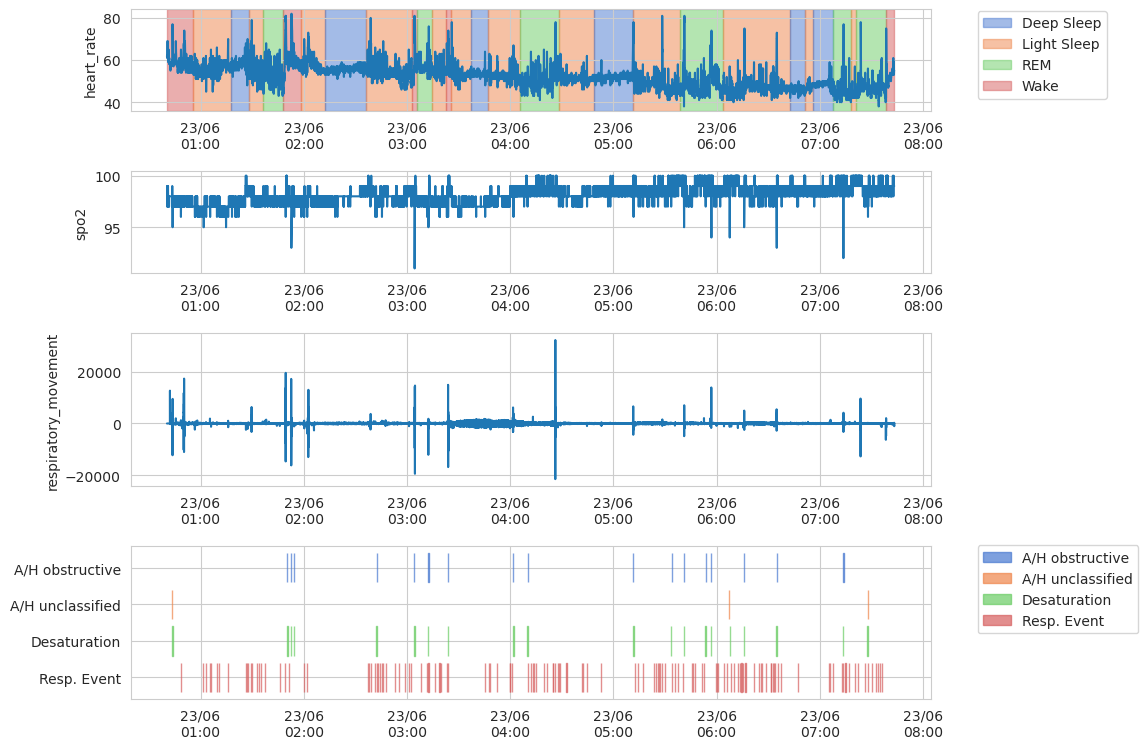

In [ ]:
#| eval: false
sns.set_style('whitegrid')

g = TimeSeriesFigure()

channels_df = format_timeseries(channels_df).set_index('collection_timestamp')
g.plot(sns.lineplot, channels_df, x='collection_timestamp', y='heart_rate',
       name='heart_rate')  # Named axis 'heart_rate'

# You can also use the `sharex` argument to share the x-axis between plots
# Named axes, such as 'heart_rate', can be referred to by name
g.plot(sns.lineplot, channels_df, x='collection_timestamp', y='spo2',
       sharex='heart_rate')

# You can increase the relative height of the plot by passing a `height` argument
g.plot(sns.lineplot, channels_df, x='collection_timestamp', y='respiratory_movement',
       sharex='heart_rate', height=1.5)

# You may add a plot to an existing axes by passing an `ax` argument to the plotting function
# Named axes, such as 'heart_rate', can be referred to by name
stage_events = ['Wake', 'Light Sleep', 'Deep Sleep', 'REM']  # Include only sleep stage events
g.plot(plot_events_fill, events_df, hue='event', y_include=stage_events,
       ax='heart_rate')

apnea_events = ['Resp. Event', 'Desaturation', 'A/H obstructive', 'A/H central', 'A/H unclassified']
g.plot(plot_events_bars, events_df, hue='event', y_include=apnea_events, height=1.5)

# Control functions to conveniently modify all axes
g.set_periodic_ticks('1h')
g.set_axis_padding(0.05)
g.set_axis_properties(xlabel='')

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()